In [30]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import ConvexHull, Delaunay


In [31]:
num = []
points = []

with open("../poisson_disk_sample3.txt", 'r') as file:
    for line in file:
        # 解析每一行并转换为浮点数
        values = list(map(float, line.split()))
        points.append(values)
points = np.array(points)

print(points.shape)

(200, 4)


In [32]:
num = []
data = []

with open("../conflict3.txt", 'r') as file:
    for line in file:
        # 解析每一行并转换为浮点数
        values = list(map(float, line.split()))
        if(len(values)==1):
            num.append(int(values[0])+1)
        else:
            data.append(values)
num  = np.array(num)
data = np.array(data)

print(data.shape)


(34777, 4)


In [40]:
num_samples = []
samples = []

with open("../surface_sample3.txt", 'r') as file:
    for line in file:
        # 解析每一行并转换为浮点数
        values = list(map(float, line.split()))
        if(len(values)==1):
            num_samples.append(int(values[0]))
        else:
            samples.append(values)
    
num_samples = np.array(num_samples)
samples = np.array(samples)
print(samples.shape)

samples_of_surface = {}
idx = 0
for i,n in enumerate(num_samples):
    samples_of_surface[i] = samples[idx:idx+n]
    idx += n
zero_num_idx = np.where(num_samples==0)[0]
print(zero_num_idx)
print(num_samples)


(720381, 3)
[]
[1164  733  749  847 1345  313 1049 1469  856 1279 1329 1597   28 1309
  695  550 1494  652  648  294  660 1490  435 1414  664  672  691 1336
 1490 1059  830  623 1331 1390  551  192 1442  211  323  219  658 1041
 1104 1053  603 1032  445  666  556 1292  381  492 1496  806 1039 1074
  840  831 1065  979  491  433  964  600 1312  672  394  917  206 1118
  465 1002  839 1683  764  519 1090  934  491  898  540  298  547  580
  709  930  315 1498 1036 1034 1136  590  713  703  772 1027 1207  585
 1362  407 1411  837   61  677  347  325  174  431  744 1029    9  436
  478  741 1077  754 1056 1202  412 1263  721  854  820  662   45 1121
 1491 1476  864  353  810 1591  931 1092  917 1442  530  978  450  664
  645  638  706  900  832  840  816  701  965  909  997  994  803  619
  551    5  792  428  547  288  924  480 1048  995  762 1114  550  993
  598  767 1280  578  634 1610  766  768 1769 1595  976 1369 1396 1050
  953 1589  581  830  842 1051  995  843  918 1488  142  974  

In [34]:
hulls = []
centers = []
bounary_vertices = {}
faces_vertices = {}
idx = 0
for i,n in enumerate(num):
    center = data[idx,:]
    centers.append(center)
    vertices = data[idx+1:idx+n,:]
    faces_vertices[i] = vertices
    vertices =np.unique(vertices,axis=0)
    bounary_vertices[i] = vertices

    vertices_pos = vertices[:,0:3]
    hull = ConvexHull(vertices_pos)
    hulls.append(hull)
    idx += n
centers = np.array(centers)
print(centers.shape)

(823, 4)


In [35]:
def is_point_in_hull(point, hull):
    # 遍历凸包的每一个面
    for eq in hull.equations:
        # 凸包的每个面方程为 ax + by + cz + d = 0
        # eq[:-1] 是面法向量 (a, b, c)，eq[-1] 是 d
        # 判断点是否在凸包的一侧（即满足 ax + by + cz + d <= 0）
        if np.dot(eq[:-1], point) + eq[-1] >= 0:
            # 如果大于 0，说明点在凸包的外面
            return False
    # 如果所有面都满足 ax + by + cz + d < 0，则点在凸包内
    return True


In [36]:

error_idx = []
idx = 0
for bvs in bounary_vertices.values():
    flag = False
    for i,p in enumerate(bvs):
        if np.any(np.all(p == bvs,axis=1)):
            continue
        flag = is_point_in_hull(p[0:3],hulls[idx])
        if flag: 
            break
    if flag:
        error_idx.append(idx)
    idx += 1


idx = 0
for center,hull in zip(centers,hulls):
    if not is_point_in_hull(center[0:3],hull):
        error_idx.append(idx)
    idx += 1

for idx,hull in enumerate(hulls):
    if len(bounary_vertices[idx]) != len(hull.vertices):
        error_idx.append(idx)
        print(idx)
        print(len(bounary_vertices[idx]),",",len(hull.vertices))

# inside_p = []
# for p in points:
#     if np.any(np.all(p == bounary_vertices[idx],axis=1)):
#         continue
#     if is_point_in_hull(p[0:3],hulls[idx]):
#         inside_p.append(p)
#         print(p[0],",",p[1],",",p[2],";")
# print(len(inside_p))


len(error_idx)

31
7 , 6
49
13 , 12
75
7 , 6
93
8 , 7
143
10 , 9
193
10 , 9
224
11 , 9
228
10 , 9
343
7 , 6
409
10 , 9
448
11 , 10
515
14 , 13
521
7 , 6
529
7 , 6
543
11 , 9
556
10 , 9
629
8 , 7
667
12 , 11
695
11 , 10


19

In [37]:
def calculate_normal(face, vertices):
    """
    计算给定面的法向量
    face: 面的顶点索引
    vertices: 所有顶点的坐标
    """
    p0, p1, p2 = vertices[face[0]], vertices[face[1]], vertices[face[2]]
    v1 = p1 - p0
    v2 = p2 - p0
    # 计算叉积来得到法向量
    normal = np.cross(v1, v2)
    # 归一化法向量
    normal = normal / np.linalg.norm(normal)
    return normal

def calculate_centroid(face, vertices):
    """
    计算面的质心
    face: 面的顶点索引
    vertices: 所有顶点的坐标
    """
    return np.mean(vertices[face], axis=0)

def plotPolygons(faces,vertices,center,selected_points=None, set_normal=False):
    vertices_pos = vertices[:,0:3]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_axis_off()

    # 绘制多面体的面
    ax.add_collection3d(Poly3DCollection(vertices_pos[faces], 
                                        facecolors ='cyan',
                                        linewidths=1, edgecolors='black', alpha=0.1))
    # 绘制每个面的法向量
    if set_normal:
        for face in faces:
            normal = calculate_normal(face, vertices_pos)
            centroid = calculate_centroid(face, vertices_pos)
            ax.quiver(centroid[0], centroid[1], centroid[2], 
                    normal[0], normal[1], normal[2], 
                    length=0.2, color='r', normalize=True)
    # 绘制顶点
    ax.scatter(vertices_pos[:, 0], vertices_pos[:, 1], vertices_pos[:, 2], color='b', s=50)
    ax.scatter(center[0], center[1], center[2], color='r', s=50)

    if selected_points is not None:
        selected_points = np.array(selected_points)
        ax.scatter(selected_points[:, 0], selected_points[:, 1], selected_points[:, 2], color='g', s=1)

    plt.show()

2
36


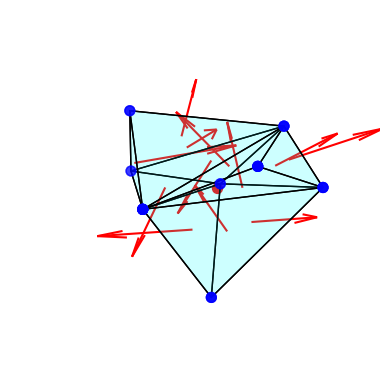

In [38]:
if(len(error_idx) == 0):
    idx = 0
else:
    idx = error_idx[0]
idx = 2
print(idx)
faces_vnum = faces_vertices[idx].shape[0]
print(faces_vnum)
simplices = np.reshape(np.arange(faces_vnum),(-1,3))

plotPolygons(simplices,faces_vertices[idx],centers[idx],set_normal=True)

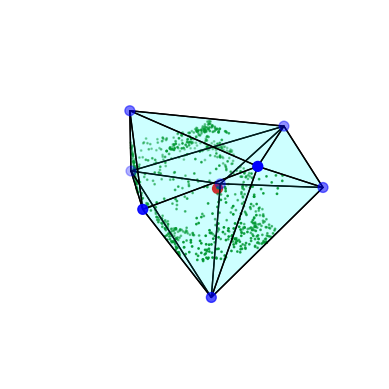

(749, 3)


In [39]:
plotPolygons(hulls[idx].simplices,bounary_vertices[idx],centers[idx],selected_points=samples_of_surface[idx])
print(samples_of_surface[idx].shape)

for vtex in bounary_vertices[idx]:
    if is_point_in_hull(vtex[0:3],hulls[idx]):
        print(vtex)